**loading custom dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import os
import zipfile
from torch.utils.data import Dataset
from io import BytesIO

# Mount Google Drive
drive.mount('/content/drive')

class BreastCancerDataset(Dataset):
    def __init__(self, zip_path, transform=None):
        self.zip_path = zip_path
        self.transform = transform
        self.samples = self._load_samples_from_zip()

        # Debug: Print the number of samples loaded
        print(f"Number of samples found: {len(self.samples)}")
        if len(self.samples) == 0:
            raise ValueError(f"No valid samples found in {self.zip_path}")

    def _load_samples_from_zip(self):
        samples = []
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                # Check if the file belongs to Benign or Malignant class based on folder structure
                if 'Benign/' in file_name and file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    samples.append((file_name, 0))  # Label 0 for Benign
                elif 'Malignant/' in file_name and file_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    samples.append((file_name, 1))  # Label 1 for Malignant
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_name, label = self.samples[idx]
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            with zip_ref.open(file_name) as file:
                image = Image.open(BytesIO(file.read())).convert('RGB')  # Load the image from zip
        if self.transform:
            image = self.transform(image)
        return image, label

dataset_path = '/content/drive/MyDrive/BCD-data.zip'
dataset = BreastCancerDataset(dataset_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of samples found: 29274


ploting image from **dataset**

**EDA**

Number of samples found: 29274


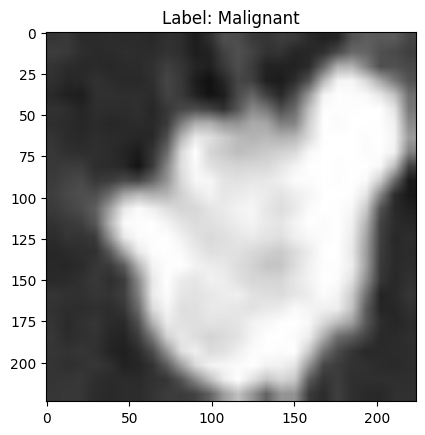

In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define any image transformations you want (e.g., resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Create the dataset and data loader
dataset = BreastCancerDataset(dataset_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=6, shuffle=True)  # Adjust batch size as needed

# Display an image from the data loader
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Select the 4th image (index 3) from the batch
image = images[3]

# Convert the image from a PyTorch tensor to a NumPy array and rearrange dimensions
image = image.numpy().transpose((1, 2, 0))

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Label: {'Benign' if labels[3].item() == 0 else 'Malignant'}")  # Use labels[3] for the correct label
plt.show()


In [3]:
from skimage import color, exposure
from skimage.feature import hog, corner_harris, corner_peaks # Import corner_harris and corner_peaks
from skimage import color, exposure
from skimage.feature import hog, corner_harris, corner_peaks # Import corner_harris and corner_peaks


** histogram of pixel values**

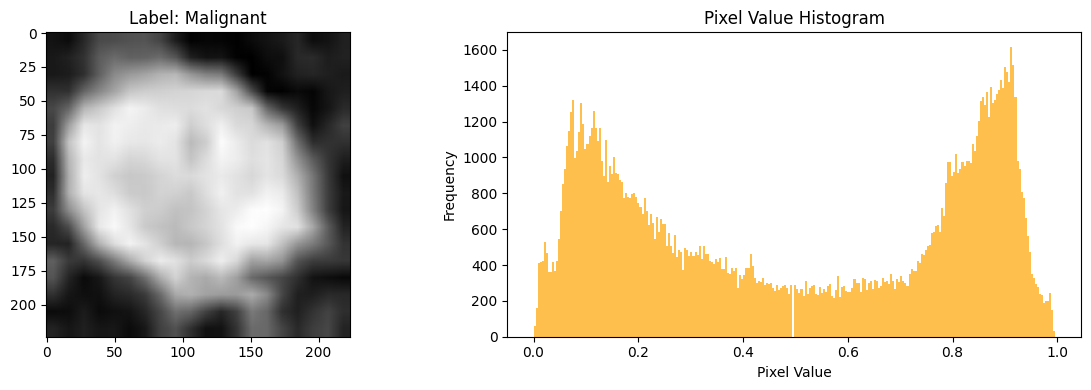

In [4]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Select the first image from the batch
image = images[0]

# Convert the image from a PyTorch tensor to a NumPy array
image = image.numpy().transpose((1, 2, 0))

# Plot the original image
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Label: {'Benign' if labels[3] == 0 else 'Malignant'}")

# Plot the histogram of pixel values
plt.subplot(1, 2, 2)
plt.hist(image.ravel(), bins=256, color='orange', alpha=0.7)
plt.title("Pixel Value Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Calculate GLCM properties

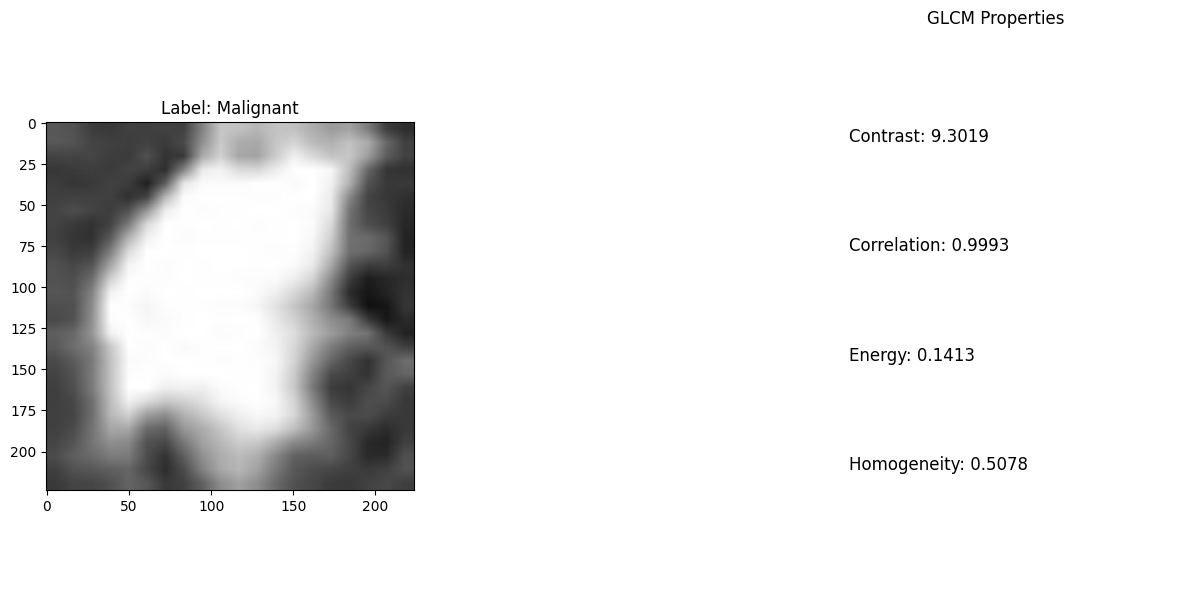

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops  # Correct import
from skimage.color import rgb2gray
import torch

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Select the first image from the batch
image = images[0]

# Convert the image from a PyTorch tensor to a NumPy array and grayscale it
image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format and ensure it's on CPU
gray_image = rgb2gray(image)  # Convert RGB image to grayscale

# Plot the original image
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title(f"Label: {'Benign' if labels[0].item() == 0 else 'Malignant'}")



# Calculate GLCM and GLCM properties
distances = [1]  # Pixel pair distance
angles = [0]  # Angle (0 degrees)
glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=distances, angles=angles, symmetric=True, normed=True)  # Using graycomatrix instead of greycomatrix

# Extract GLCM properties
contrast = graycoprops(glcm, 'contrast')[0, 0]  # Using graycoprops instead of greycoprops
correlation = graycoprops(glcm, 'correlation')[0, 0]  # Using graycoprops instead of greycoprops
energy = graycoprops(glcm, 'energy')[0, 0]  # Using graycoprops instead of greycoprops
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]  # Using graycoprops instead of greycoprops

# Display GLCM properties
plt.subplot(1, 3, 3)
plt.text(0.1, 0.8, f'Contrast: {contrast:.4f}', fontsize=12)
plt.text(0.1, 0.6, f'Correlation: {correlation:.4f}', fontsize=12)
plt.text(0.1, 0.4, f'Energy: {energy:.4f}', fontsize=12)
plt.text(0.1, 0.2, f'Homogeneity: {homogeneity:.4f}', fontsize=12)
plt.axis('off')
plt.title("GLCM Properties")

plt.tight_layout()
plt.show()

**GLMC**

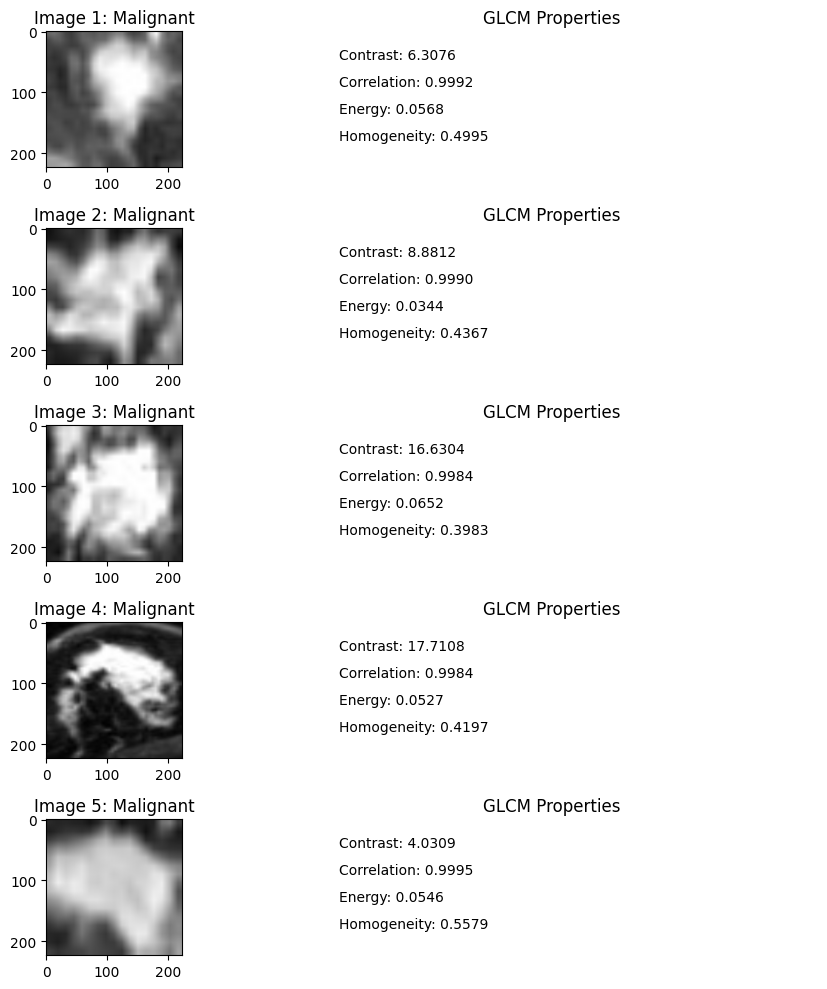

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import torch

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Define parameters for GLCM calculation
distances = [1]  # Pixel pair distance
angles = [0]  # Angle (0 degrees)

# Process the first 5 images
num_images = min(5, len(images))
plt.figure(figsize=(10, 10))

for idx in range(num_images):
    # Select the image and label
    image = images[idx]
    label = labels[idx].item()

    # Convert the image from a PyTorch tensor to a NumPy array and grayscale it
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC format and ensure it's on CPU
    gray_image = rgb2gray(image)  # Convert RGB image to grayscale

    # Scale grayscale image to 0-255 for GLCM computation
    gray_image = (gray_image * 255).astype(np.uint8)

    # Calculate GLCM and GLCM properties
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # Plot the image and GLCM properties
    plt.subplot(num_images, 2, idx * 2 + 1)
    plt.imshow(image)
    plt.title(f"Image {idx+1}: {'Benign' if label == 0 else 'Malignant'}")

    plt.subplot(num_images, 2, idx * 2 + 2)
    plt.text(0.1, 0.8, f'Contrast: {contrast:.4f}', fontsize=10)
    plt.text(0.1, 0.6, f'Correlation: {correlation:.4f}', fontsize=10)
    plt.text(0.1, 0.4, f'Energy: {energy:.4f}', fontsize=10)
    plt.text(0.1, 0.2, f'Homogeneity: {homogeneity:.4f}', fontsize=10)
    plt.axis('off')
    plt.title("GLCM Properties")

plt.tight_layout()
plt.show()


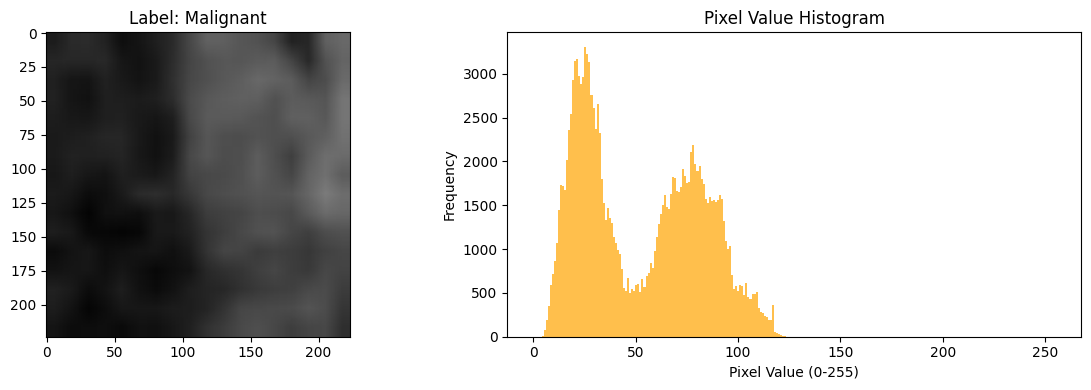

In [7]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Adjust the index to a value within the batch size
index = min(5, len(images) - 1)  # Ensure index is within bounds

# Select the image and label
image = images[index]
label = labels[index].item()

# Convert the image from a PyTorch tensor to a NumPy array and transpose it to HxWxC
image = image.numpy().transpose((1, 2, 0))

# If the image is normalized between 0 and 1, convert it to 0-255 range
image = (image * 255).astype(int)

# Plot the original image
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Label: {'Benign' if label == 0 else 'Malignant'}")

# Plot the histogram of pixel values
plt.subplot(1, 2, 2)
plt.hist(image.ravel(), bins=256, color='orange', alpha=0.7, range=(0, 255))
plt.title("Pixel Value Histogram")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'HOG Image')

<Figure size 1200x500 with 0 Axes>

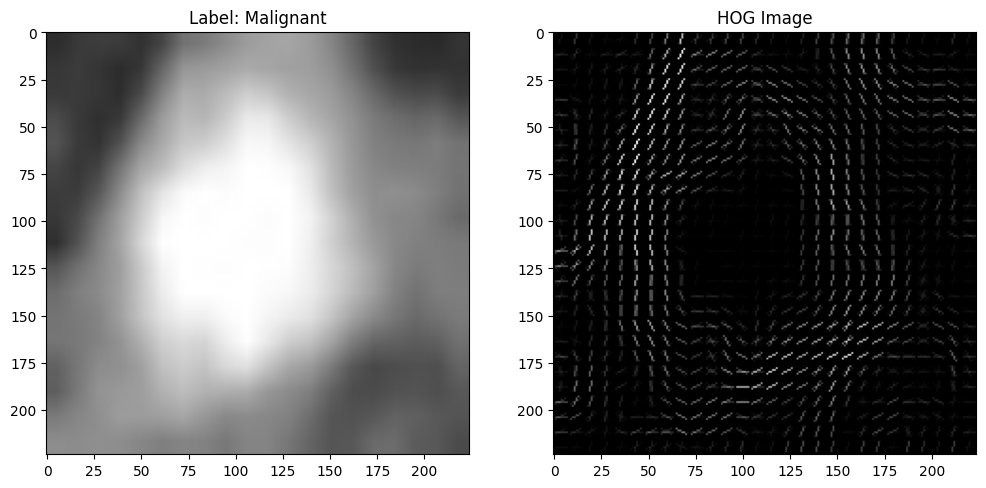

In [8]:
image, labels = next(iter(train_loader))  # Get a batch of images and labels
image = image[5]
image = image.numpy().transpose((1, 2, 0))
# Convert the image to grayscale
gray_image = color.rgb2gray(image)

plt.figure(figsize=(12, 5))
# Compute HOG features and the HOG image for visualization
hog_features, hog_image = hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True,
    channel_axis=None
)

# Plot the original image and the HOG image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Label: {'Benign' if labels[5] == 0 else 'Malignant'}")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Image")

coner dectection



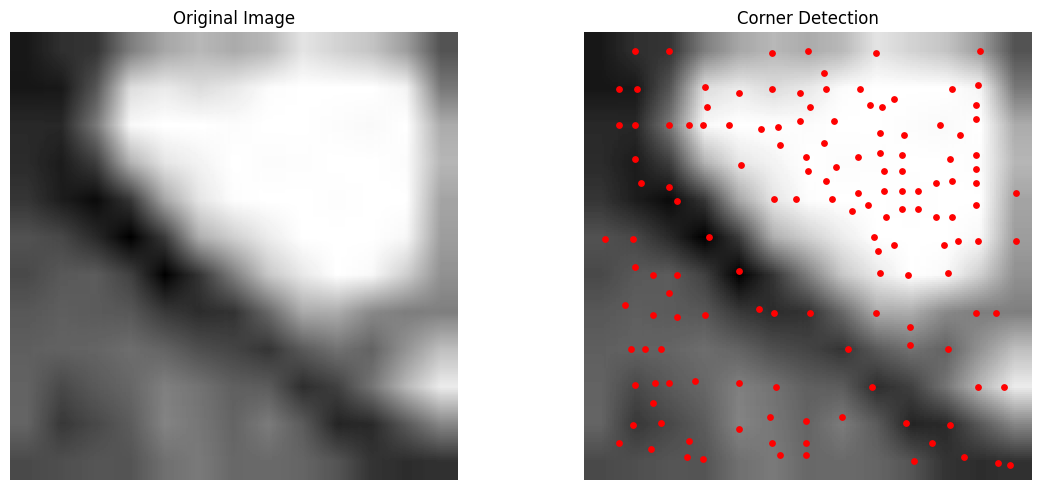

Number of corners detected: 143


In [9]:
#coner dectection
from skimage.feature import hog, corner_harris, corner_peaks # Import corner_harris and corner_peaks

image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[5]
image = image.numpy().transpose((1, 2, 0))

gray_image = color.rgb2gray(image)

# Perform Harris corner detection
corners = corner_harris(gray_image)

# Perform corner peak detection
coords = corner_peaks(corners, min_distance=5)

# Plot the original image with detected corners
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=15, c='red', marker='o')
plt.title('Corner Detection')
plt.axis('off')

plt.tight_layout()
plt.show()

# Display number of corners detected
print(f'Number of corners detected: {len(coords)}')

Sobel operator

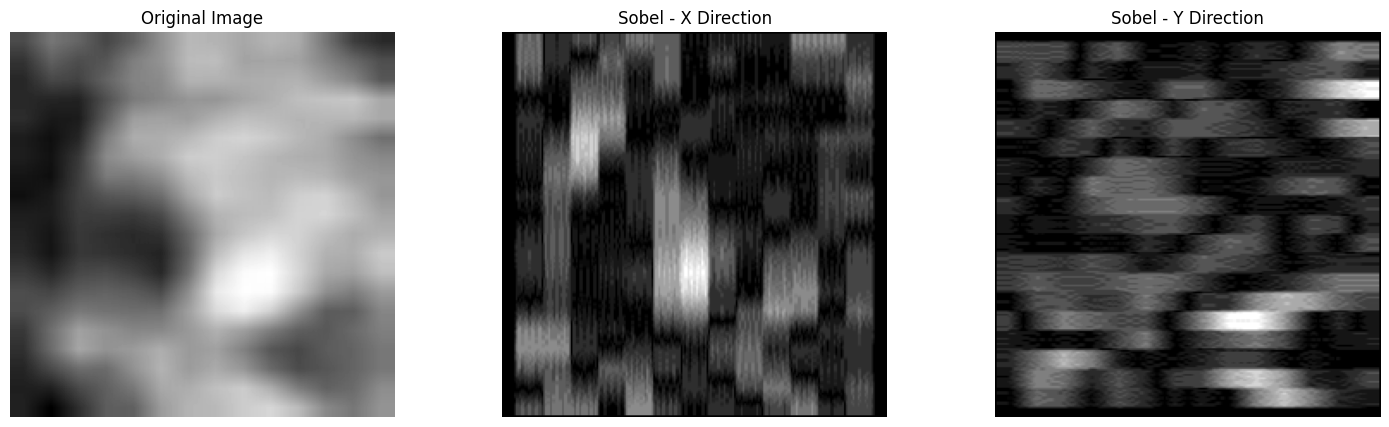

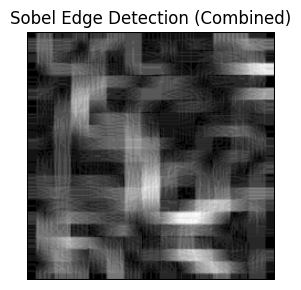

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io
from numba import jit, prange

# Define Sobel operator kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

# Define the custom convolution function with Numba for speedup
@jit(nopython=True, parallel=True)
def convolve(x, h):
    xh, xw = x.shape
    hh, hw = h.shape
    # Kernel radius
    rh, rw = np.array(h.shape)//2
    # Init output
    output = np.zeros(x.shape)
    for n1 in prange(rh, xh-rh):
        for n2 in prange(rw, xw-rw):
            value = 0
            for k1 in prange(hh):
                for k2 in prange(hw):
                    value += h[k1, k2]*x[n1 + k1 - rh, n2 + k2 - rw]
            output[n1, n2] = value
    return output

# Load the image
image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[5]
image = image.numpy().transpose((1, 2, 0))
# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply the custom convolution with the Sobel operator in the x and y directions
gradient_x = convolve(gray_image, sobel_x)
gradient_y = convolve(gray_image, sobel_y)

# Combine the Sobel x and y results
sobel_combined = np.hypot(gradient_x, gradient_y)

# Normalize the combined result to range [0, 1]
sobel_combined /= sobel_combined.max()

# Plot the original image and the Sobel edge-detected images
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(gradient_x), cmap='gray')
plt.title('Sobel - X Direction')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(gradient_y), cmap='gray')
plt.title('Sobel - Y Direction')
plt.axis('off')

plt.figure(figsize=(3, 3))
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Edge Detection (Combined)')
plt.axis('off')

plt.tight_layout()
plt.show()




Found '/content/clasification-roi.zip', extracting now...
Dataset extracted successfully!

Listing contents of the extracted directory:
/content/clasification-roi contains directories: ['test', 'val', 'train'] and files: []
/content/clasification-roi/test contains directories: ['Malignant', 'Benign'] and files: []
/content/clasification-roi/test/Malignant contains directories: ['BreaDM-Ma-1923', 'BreaDM-Ma-1916', 'BreaDM-Ma-2026', 'BreaDM-Ma-2012', 'BreaDM-Ma-2131', 'BreaDM-Ma-1921', 'BreaDM-Ma-2118', 'BreaDM-Ma-2125', 'BreaDM-Ma-2134', 'BreaDM-Ma-2141', 'BreaDM-Ma-1801', 'BreaDM-Ma-1919', 'BreaDM-Ma-1908', 'BreaDM-Ma-2039', 'BreaDM-Ma-2027', 'BreaDM-Ma-2038', 'BreaDM-Ma-2140', 'BreaDM-Ma-1909', 'BreaDM-Ma-2044', 'BreaDM-Ma-1915', 'BreaDM-Ma-2007', 'BreaDM-Ma-2043', 'BreaDM-Ma-2122', 'BreaDM-Ma-2109', 'BreaDM-Ma-1824', 'BreaDM-Ma-2107', 'BreaDM-Ma-2126', 'BreaDM-Ma-2116', 'BreaDM-Ma-1821', 'BreaDM-Ma-2108'] and files: []
/content/clasification-roi/test/Malignant/BreaDM-Ma-1923 contains

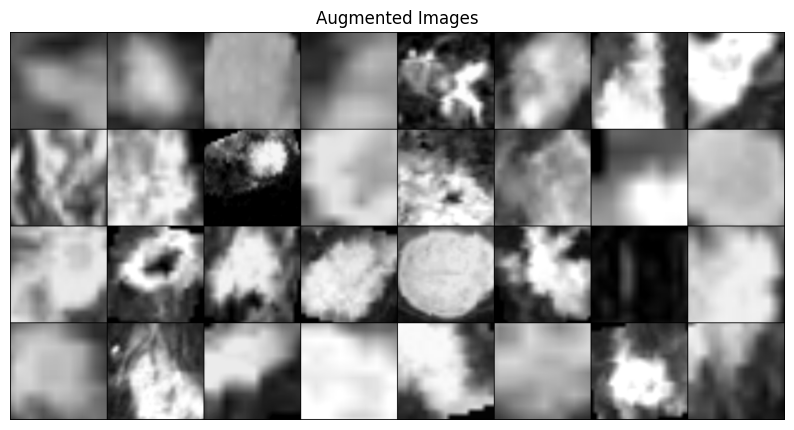

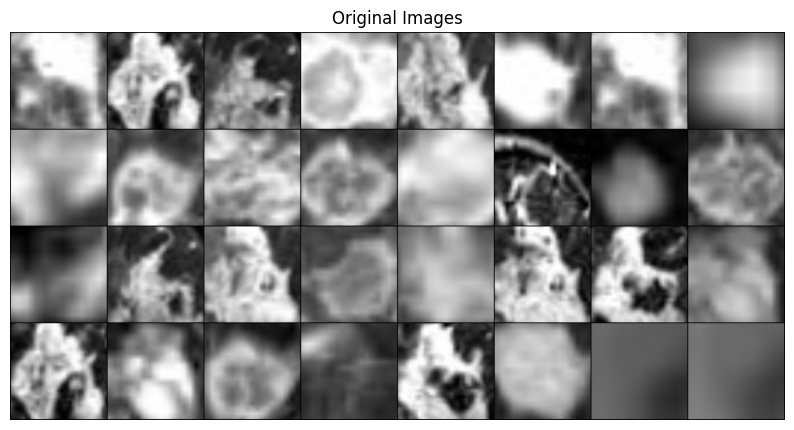

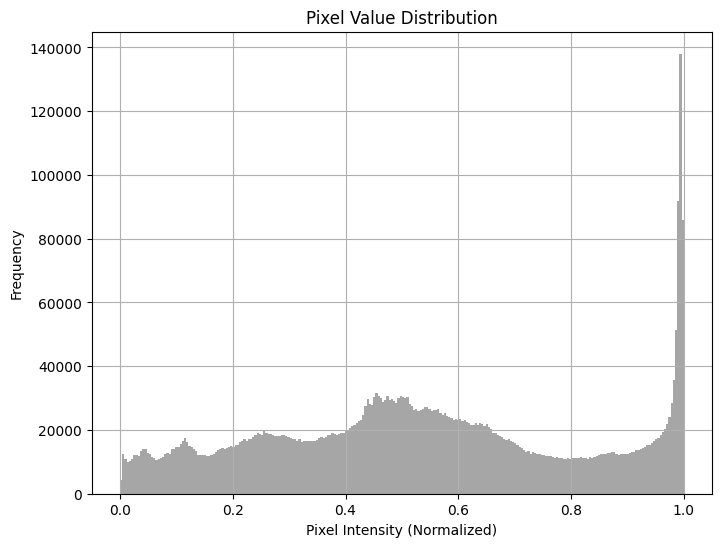

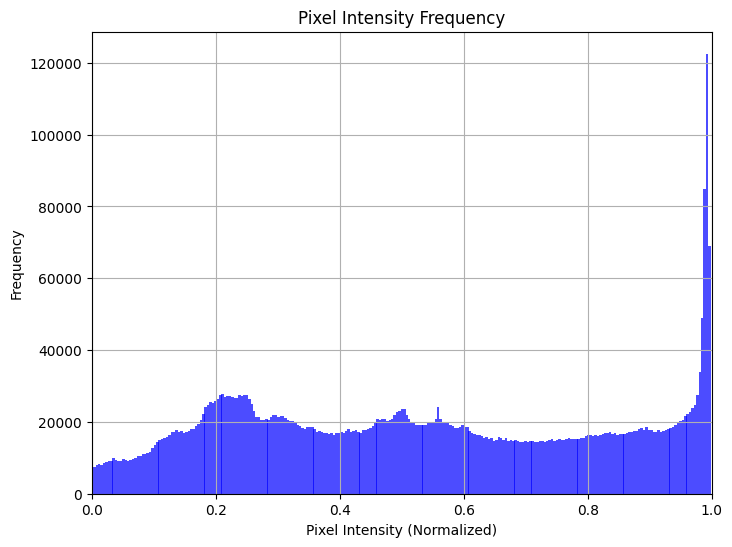

In [11]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

# Step 1: Assume the zip file has been uploaded to Colab manually
dataset_zip = '/content/clasification-roi.zip'  # Path to the uploaded zip file
dataset_dir = '/content/clasification-roi'  # Directory where the dataset will be extracted

# Step 2: Check if the zip file exists and extract it
if os.path.exists(dataset_zip):
    print(f"Found '{dataset_zip}', extracting now...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("Dataset extracted successfully!")
else:
    print(f"File '{dataset_zip}' not found!")

# Step 3: List the contents of the extracted directory to inspect the structure
print("\nListing contents of the extracted directory:")
for root, dirs, files in os.walk(dataset_dir):
    print(root, "contains directories:", dirs, "and files:", files)

# Step 4: Define transformations
augmentations = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.Resize(256),  # Resize to a larger size before cropping
        transforms.RandomResizedCrop(224),  # Crop to 224x224
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize to a larger size before cropping
        transforms.CenterCrop(224),  # Center crop to 224x224
        transforms.ToTensor(),
    ]),
}

# Step 5: Load datasets
dataset_folders = {split: datasets.ImageFolder(os.path.join(dataset_dir, split), augmentations[split])
                   for split in ['train', 'val']}

# Step 6: Initialize data loaders for both training and validation sets
batch_loaders = {split: DataLoader(dataset_folders[split], batch_size=32, shuffle=True)
                 for split in ['train', 'val']}

# Step 7: Retrieve class names from the training dataset
categories = dataset_folders['train'].classes
print(f"\nDetected Classes: {categories}")

# Step 8: Function to visualize a batch of augmented images
def visualize_augmented_images():
    inputs, classes = next(iter(batch_loaders['train']))
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))
    plt.title("Augmented Images")
    plt.axis('off')
    plt.show()

# Step 9: Function to visualize original images from the validation set
def visualize_original_images():
    inputs, classes = next(iter(batch_loaders['val']))
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))
    plt.title("Original Images")
    plt.axis('off')
    plt.show()

# Step 10: Visualize images (both augmented and original)
visualize_augmented_images()
visualize_original_images()

# Step 11: Plot pixel value histograms for the images
def plot_pixel_histogram():
    # Collect all pixel values from the validation set for histogram
    inputs, _ = next(iter(batch_loaders['val']))
    pixels = inputs.numpy().ravel()  # Flatten all pixel values

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(pixels, bins=256, range=(0, 1), color='gray', alpha=0.7)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Intensity (Normalized)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

# Step 12: Function to plot pixel intensity frequency
def plot_pixel_frequency():
    inputs, _ = next(iter(batch_loaders['val']))
    pixels = inputs.numpy().ravel()  # Flatten all pixel values

    # Calculate frequency of pixel values
    pixel_freq, bins = np.histogram(pixels, bins=256, range=(0, 1))

    # Plot histogram with pixel intensity on the x-axis and frequency on the y-axis
    plt.figure(figsize=(8, 6))
    plt.bar(bins[:-1], pixel_freq, width=0.004, color='blue', alpha=0.7)  # Bar plot for pixel frequency
    plt.title('Pixel Intensity Frequency')
    plt.xlabel('Pixel Intensity (Normalized)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.xlim(0, 1)  # Set x-axis limits
    plt.show()

# Step 13: Display pixel value histogram and pixel frequency
plot_pixel_histogram()
plot_pixel_frequency()


Found '/content/clasification-roi.zip', extracting now...
Dataset extracted successfully!
Processing: /content/clasification-roi/test/Malignant/BreaDM-Ma-1923/VIBRANT/p-024.jpg


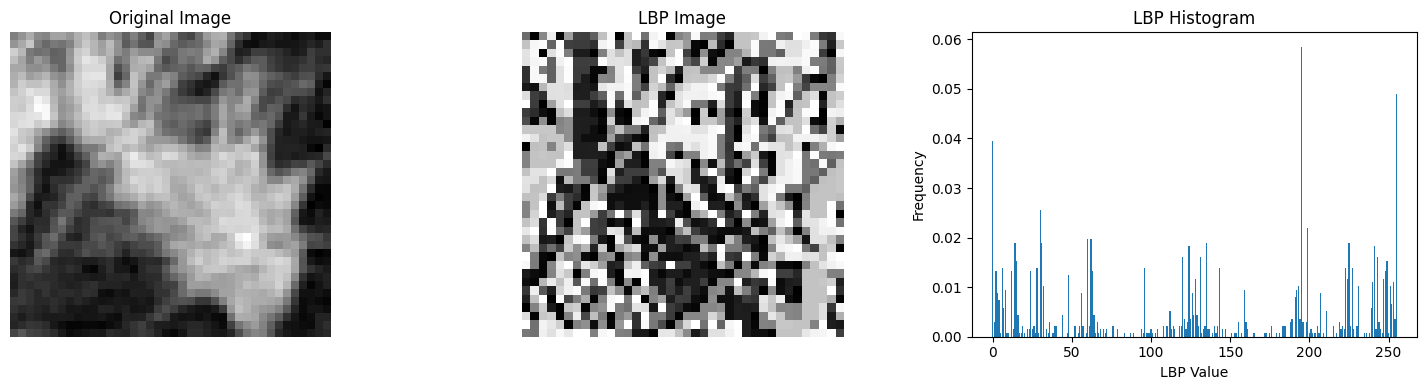

In [12]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Assume the zip file has been uploaded to Colab manually
dataset_zip = '/content/clasification-roi.zip'  # Path to the uploaded zip file
dataset_dir = '/content/clasification-roi'  # Directory where the dataset will be extracted

# Step 2: Check if the zip file exists and extract it
if os.path.exists(dataset_zip):
    print(f"Found '{dataset_zip}', extracting now...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("Dataset extracted successfully!")
else:
    print(f"File '{dataset_zip}' not found!")

# Step 3: Define LBP functions
def get_pixel(img, center, x, y):
    """
    Get pixel value at coordinate (x,y) or return 0 if it's outside the image
    """
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except IndexError:
        pass
    return new_value

def calculate_lbp(image, radius=3):
    """
    Calculate the Local Binary Pattern of an image
    """
    height, width = image.shape
    lbp_image = np.zeros((height-2, width-2), np.uint8)
    neighbors = radius*2

    # Iterate through the image pixels (excluding borders)
    for i in range(1, height-1):
        for j in range(1, width-1):
            center = image[i, j]
            binary_code = []

            # Compare with 8 neighboring pixels
            binary_code.append(get_pixel(image, center, i-1, j-1))  # Top-left
            binary_code.append(get_pixel(image, center, i-1, j))    # Top
            binary_code.append(get_pixel(image, center, i-1, j+1))  # Top-right
            binary_code.append(get_pixel(image, center, i, j+1))    # Right
            binary_code.append(get_pixel(image, center, i+1, j+1))  # Bottom-right
            binary_code.append(get_pixel(image, center, i+1, j))    # Bottom
            binary_code.append(get_pixel(image, center, i+1, j-1))  # Bottom-left
            binary_code.append(get_pixel(image, center, i, j-1))    # Left

            # Convert binary code to decimal
            lbp_value = 0
            for idx, value in enumerate(binary_code):
                lbp_value += value * (2 ** idx)

            lbp_image[i-1, j-1] = lbp_value

    # Calculate the histogram
    histogram = np.histogram(lbp_image.ravel(), bins=np.arange(0, 257))[0]

    # Normalize the histogram
    histogram = histogram.astype('float32')
    histogram /= (histogram.sum() + 1e-7)

    return lbp_image, histogram

def visualize_lbp_results(original_image, lbp_image, histogram):
    """
    Visualize the original image, LBP image, and LBP histogram
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    # Plot original image
    ax1.imshow(original_image, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Plot LBP image
    ax2.imshow(lbp_image, cmap='gray')
    ax2.set_title('LBP Image')
    ax2.axis('off')

    # Plot histogram
    ax3.bar(range(256), histogram)
    ax3.set_title('LBP Histogram')
    ax3.set_xlabel('LBP Value')
    ax3.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Step 4: Process and visualize only one image from the dataset directory
def process_one_image_in_directory(directory):
    """
    Process and visualize only one image from the directory through the LBP algorithm
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(root, file)
                print(f"Processing: {image_path}")

                # Read the image
                image = cv2.imread(image_path)
                if len(image.shape) == 3:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Calculate LBP
                lbp_image, histogram = calculate_lbp(image)

                # Visualize the result
                visualize_lbp_results(image, lbp_image, histogram)

                # Only process the first image
                return

# Example usage
if __name__ == "__main__":
    process_one_image_in_directory(dataset_dir)


Local Binary Pattern

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


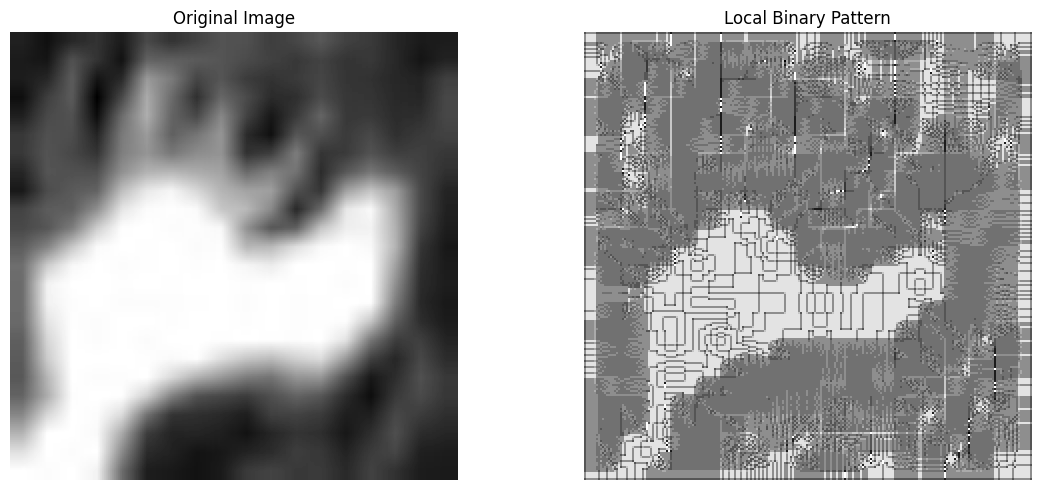

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import local_binary_pattern
import torch

# Parameters for LBP
radius = 1  # Radius of the circle
n_points = 8 * radius  # Number of points considered for the LBP

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Choose an image from the batch (assuming batch size is large enough)
image = images[5]  # Choose the 5th image

# Convert the image from PyTorch tensor to NumPy array and move it to CPU if needed
image = image.permute(1, 2, 0).cpu().numpy()

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Local Binary Pattern
lbp_image = local_binary_pattern(gray_image, n_points, radius, method='uniform')

# Plot the original image and the LBP image
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern')
plt.axis('off')

plt.tight_layout()
plt.show()


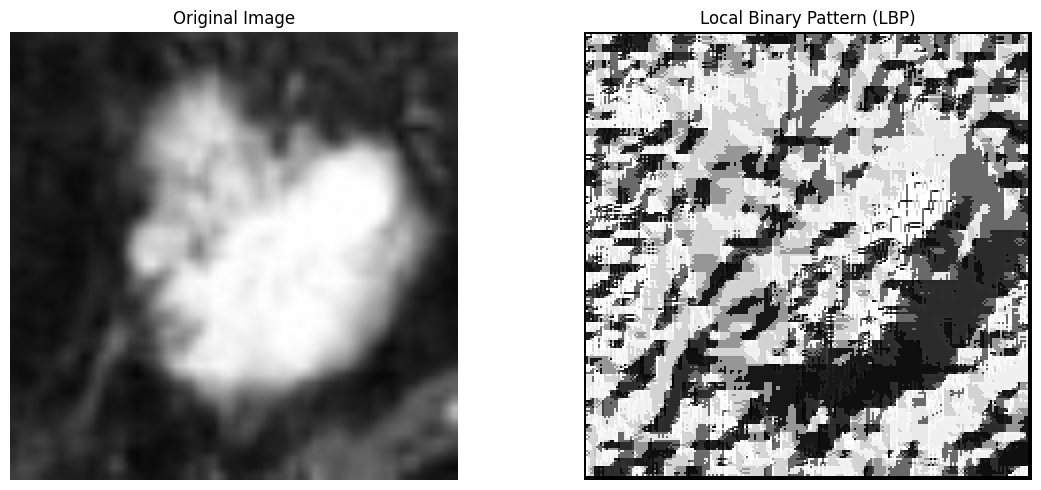

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def lbp_scratch(image):
    """
    Computes the Local Binary Pattern (LBP) for an input image from scratch.
    """
    # Step 0: Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgLBP = np.zeros_like(gray_image)  # Initialize the LBP image

    # Define the size of the neighborhood (3x3 window)
    neighboor = 3

    # Iterate over each pixel in the grayscale image, excluding the border pixels
    for ih in range(0, gray_image.shape[0] - neighboor):
        for iw in range(0, gray_image.shape[1] - neighboor):
            # Step 1: Extract a 3x3 region centered on the current pixel
            img = gray_image[ih:ih + neighboor, iw:iw + neighboor]
            center = img[1, 1]  # The center pixel value of the 3x3 region

            # Step 2: Binary operation - Compare each neighbor's value with the center pixel
            img01 = (img >= center) * 1.0  # Threshold the 3x3 region

            # Step 3: Flatten the thresholded image into a vector, excluding the center pixel
            img01_vector = img01.flatten()
            img01_vector = np.delete(img01_vector, 4)  # Remove the center pixel

            # Step 4: Convert the binary pattern to a decimal number
            where_img01_vector = np.where(img01_vector)[0]  # Indices where the value is 1
            if len(where_img01_vector) >= 1:
                num = np.sum(2 ** where_img01_vector)  # Convert binary to decimal
            else:
                num = 0  # If all surrounding pixels are smaller, assign 0

            # Step 5: Assign the LBP value to the central pixel of the output image
            imgLBP[ih + 1, iw + 1] = num

    return imgLBP

# Load an example image (substitute with your image)
image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[4]
image = image.numpy().transpose((1, 2, 0))


# Compute LBP using the custom function
lbp_image = lbp_scratch(image)

# Display the original and LBP images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern (LBP)')
plt.axis('off')

plt.tight_layout()
plt.show()


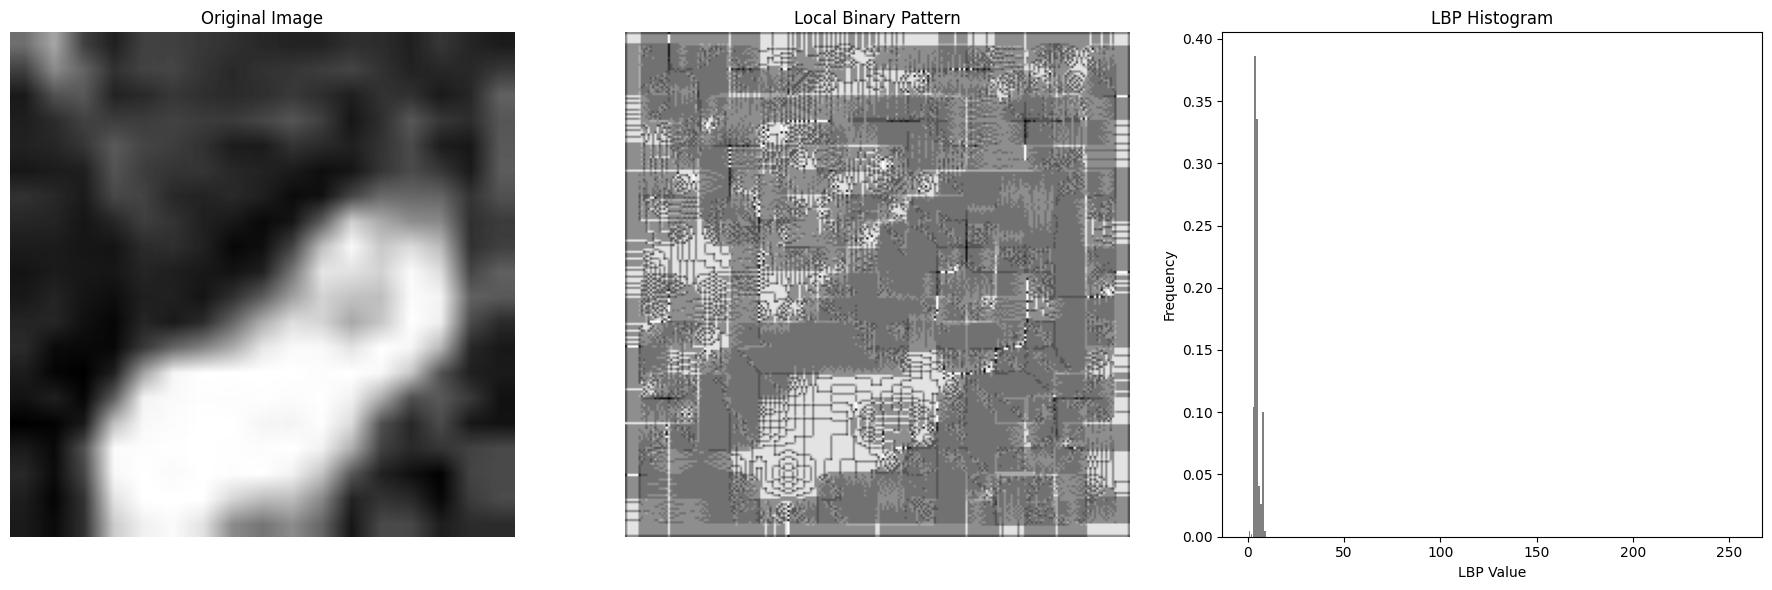

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.feature import local_binary_pattern

# Parameters for LBP
radius = 1  # Radius of the circle
n_points = 8 * radius  # Number of points considered for the LBP

# Load the image
# Load the image
image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[5]
image = image.numpy().transpose((1, 2, 0))
# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Local Binary Pattern
lbp_image = local_binary_pattern(gray_image, n_points, radius, method='uniform')


# Compute the histogram of LBP with values ranging from 0 to 255
n_bins = 256  # Number of bins for the histogram (0 to 255)
hist, bins = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, 255), density=True)
# Compute the histogram of LBP
#n_bins = int(lbp_image.max() + 1)  # Number of bins in the histogram
#hist, bins = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, n_bins), density=True)


# Plot the original image, LBP image, and the LBP histogram
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(lbp_image, cmap='gray')
plt.title('Local Binary Pattern')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.bar(bins[:-1], hist, width=0.8, color='gray')
plt.title('LBP Histogram')
plt.xlabel('LBP Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


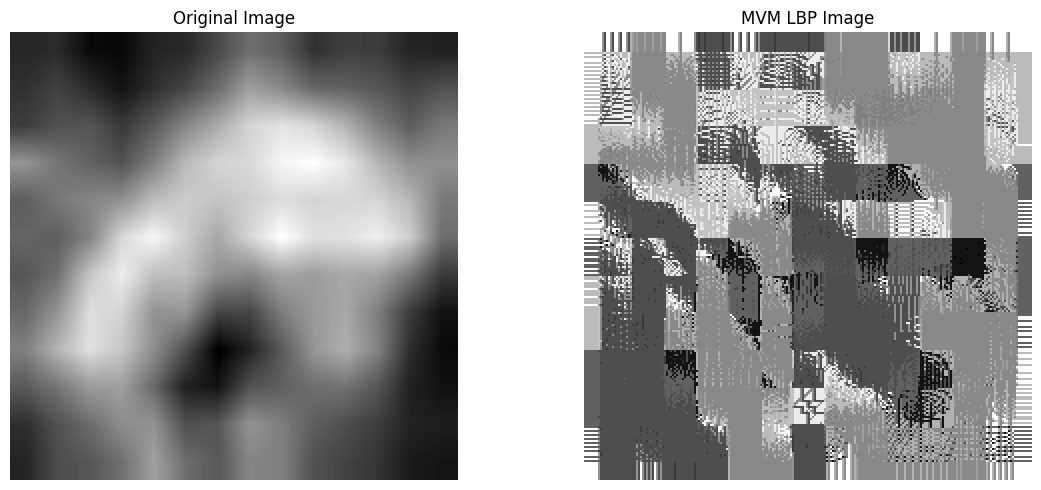

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import local_binary_pattern
from scipy.ndimage import generic_filter

radius = 1  # Radius of the circle
n_points = 8 * radius  # Number of points considered for the LBP

# Load the image
image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[5]
image = image.numpy().transpose((1, 2, 0))

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Function to compute the mean, variance, and median-based LBP
def mvm_lbp(pixel_values):
    central_pixel = pixel_values[len(pixel_values) // 2]
    neighbors = pixel_values[:len(pixel_values) // 2]
    mean_val = np.mean(neighbors)
    variance_val = np.var(neighbors)
    median_val = np.median(neighbors)

    # Compute the LBP using mean, variance, and median as thresholds
    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))
    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))
    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))

    # Combine the results by averaging (alternative approaches can be used)
    combined_lbp = (lbp_mean + lbp_variance + lbp_median) / 3
    return combined_lbp

# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)
filter_size = (2 * radius + 1, 2 * radius + 1)

# Apply the MVM LBP filter to the image
mvm_lbp_image = generic_filter(gray_image, mvm_lbp, size=filter_size)

# Plot the original image and the MVM LBP image
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mvm_lbp_image, cmap='gray')
plt.title('MVM LBP Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy.ndimage import generic_filter

radius = 1  # Radius of the circle
n_points = 8 * radius  # Number of points considered for the LBP

# Load a batch of 5 images
images, labels = next(iter(train_loader))  # Get a batch of images and labels

# Function to compute the mean, variance, and median-based LBP
def mvm_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    mean_val = np.mean(neighbors)
    variance_val = np.var(neighbors)
    median_val = np.median(neighbors)

    # Compute the LBP using mean, variance, and median as thresholds
    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))
    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))
    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))

    # Combine the results by averaging
    combined_lbp = (lbp_mean + lbp_variance + lbp_median) / 3
    return combined_lbp

# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)
filter_size = (2 * radius + 1, 2 * radius + 1)

# Set up the plot for 5 images
plt.figure(figsize=(15, 6))

for i in range(5):
    # Select the ith image from the batch and process it
    image = images[i].numpy().transpose((1, 2, 0))  # Convert to HxWxC format
    gray_image = color.rgb2gray(image)  # Convert to grayscale

    # Apply the MVM LBP filter to the grayscale image
    mvm_lbp_image = generic_filter(gray_image, mvm_lbp, size=filter_size)

    # Plot the original and the MVM LBP image side by side
    plt.subplot(2, 5, i + 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(mvm_lbp_image, cmap='gray')
    plt.title(f'MVM LBP Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy.ndimage import generic_filter

radius = 1  # Radius of the circle
n_points = 8 * radius  # Number of points considered for the LBP

# Load the image
image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[5]
image = image.numpy().transpose((1, 2, 0))

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Function to compute Mean-based LBP
def mean_based_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    mean_val = np.mean(neighbors)
    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))
    return lbp_mean

# Function to compute Variance-based LBP
def variance_based_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    variance_val = np.var(neighbors)
    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))
    return lbp_variance

# Function to compute Median-based LBP
def median_based_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    median_val = np.median(neighbors)
    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))
    return lbp_median

# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)
filter_size = (2 * radius + 1, 2 * radius + 1)

# Apply the Mean, Variance, and Median LBP filters to the image
mean_lbp_image = generic_filter(gray_image, mean_based_lbp, size=filter_size)
variance_lbp_image = generic_filter(gray_image, variance_based_lbp, size=filter_size)
median_lbp_image = generic_filter(gray_image, median_based_lbp, size=filter_size)

# Plot the original image and the Mean, Variance, and Median LBP images
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mean_lbp_image, cmap='gray')
plt.title('Mean-based LBP')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(variance_lbp_image, cmap='gray')
plt.title('Variance-based LBP')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(median_lbp_image, cmap='gray')
plt.title('Median-based LBP')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy.ndimage import generic_filter

radius = 1  # Radius of the circle
n_points = 8 * radius  # Number of points considered for the LBP

# Load the image
image, labels = next(iter(train_loader))  # Get a batch of images and labels

image = image[5]
image = image.numpy().transpose((1, 2, 0))

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Function to compute Mean-based LBP
def mean_based_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    mean_val = np.mean(neighbors)
    lbp_mean = np.sum((neighbors >= mean_val).astype(int) * (1 << np.arange(len(neighbors))))
    return lbp_mean

# Function to compute Variance-based LBP
def variance_based_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    variance_val = np.var(neighbors)
    lbp_variance = np.sum((neighbors >= variance_val).astype(int) * (1 << np.arange(len(neighbors))))
    return lbp_variance

# Function to compute Median-based LBP
def median_based_lbp(pixel_values):
    neighbors = pixel_values[:len(pixel_values) // 2]
    median_val = np.median(neighbors)
    lbp_median = np.sum((neighbors >= median_val).astype(int) * (1 << np.arange(len(neighbors))))
    return lbp_median

# Define the size of the filter (3x3 for radius=1, 5x5 for radius=2, etc.)
filter_size = (2 * radius + 1, 2 * radius + 1)

# Apply the Mean, Variance, and Median LBP filters to the image
mean_lbp_image = generic_filter(gray_image, mean_based_lbp, size=filter_size)
variance_lbp_image = generic_filter(gray_image, variance_based_lbp, size=filter_size)
median_lbp_image = generic_filter(gray_image, median_based_lbp, size=filter_size)

# Normalize the variance LBP image for better visualization
variance_lbp_image_normalized = (variance_lbp_image - np.min(variance_lbp_image)) / (np.max(variance_lbp_image) - np.min(variance_lbp_image))

# Plot the original image and the Mean, Variance (normalized), and Median LBP images
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mean_lbp_image, cmap='gray')
plt.title('Mean-based LBP')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(variance_lbp_image_normalized, cmap='gray')
plt.title('Variance-based LBP (Normalized)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(median_lbp_image, cmap='gray')
plt.title('Median-based LBP')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(224),                    # Resize the image to 256x256
    transforms.CenterCrop(224),                # Center crop to 224x224
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with ImageNet mean and std
])

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, file) for file in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB image
        if self.transform:
            image = self.transform(image)
        return image


In [ ]:
import torch

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

vgg16.eval()

print(vgg16)

Model training


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class customVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(customVGG16, self).__init__()

        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Extract features and avgpool layers
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Linear layer with input size 512 7 7 and output size 4096
            nn.ReLU(),                    # ReLU activation function
            nn.Dropout(),                 # Dropout
            nn.Linear(4096, 4096),         # Another linear layer with input size 4096 and output size 4096
            nn.ReLU(),                    # ReLU activation
            nn.Dropout(),                 # Dropout layer
            nn.Linear(4096, num_classes)  # Final Linear layer with output size equal to number of classes
        )

    # Forward Method (Make sure this is outside the __init__ method)
    def forward(self, x):
        # Pass input through the features layer
        x = self.features(x)
        # Pass through the AVGpool layer
        x = self.avgpool(x)
        # Reshape output to a 2D tensor
        x = torch.flatten(x, 1)
        # Pass through the classifier
        x = self.classifier(x)

        return x


In [ ]:
model = customVGG16()
print(model)

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        # Initialize best_score if not set, and check for improvement
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            self.trace_func(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


train VGG16


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train function

In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
def train(epoch, model, num_epochs, loader, criterion, l2_decay):
    learing_rate = max(lr*(0.1**(epoch//10)),1e-5)
    optimizer = torch.optim.SGD(model.parameters(), lr= learing_rate, momentum=0.9, weight_decay=l2_decay)
    model.train()
    correct = 0
    for data, label in tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        data = data.float().cuda()

        label = label.long().cuda()

        output = model(data)
        optimizer.zero_grad()
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()
        optimizer.step()

        pred = output.data.max(1)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

    print(f'train accuracy: {100. * correct / len(loader.dataset)}%')



In [ ]:
!pip install --upgrade scikit-learn

function evaluates a trained PyTorch model on a test dataset and calculates key metrics like loss, accuracy, and probabilities for further analysis.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

def test(model, test_dataloader):
    name = 'test'  # test dataset identifier
    len_test_dataloader = len(test_dataloader.dataset)  # length of test dataset
    model.eval()
    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    labels = ['benign', 'malignant']  # class labels

    for data, target in test_dataloader:  # use test_dataloader instead of val_dataloader
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        test_output = model(data)  # changing variable name to test_output
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()  # test loss

        pred = test_output.data.max(1)[1]  # get the index of the max log-probability
        all_predictions.append(pred.cpu().numpy())

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()  # get probabilities
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()  # count correct predictions

    # Flatten the list of predictions
    all_predictions = [i for item in all_predictions for i in item]

    # Return the accuracy and loss
    accuracy = correct / len_test_dataloader
    avg_loss = test_loss / len_test_dataloader
    return avg_loss, accuracy, all_predictions, possibilities


validation function

Evaluate the model on unseen data (validation set).
Compute key metrics:
Loss: Average loss across all validation samples.
Accuracy: Percentage of correctly predicted samples.
AUC (Area Under the Curve): A performance metric that shows how well the model distinguishes between classes.
Specificity and Sensitivity: Quantify the true negative rate and true positive rate, respectively.
Confusion Matrix: A matrix showing the true positives, false positives, true negatives, and false negative

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
import torch
import torch.nn.functional as F
import numpy as np

def validation(model, val_loader):
    name = 'validation'
    len_val_dataloader = len(val_loader.dataset)
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []  # Corrected typo: 'all_prediction' to 'all_predictions'
    possibilities = None  # Corrected typo: 'possibiltys' to 'possibilities'

    for data, target in val_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        val_output = model(data)

        # Calculate test loss
        test_loss += F.nll_loss(F.log_softmax(val_output, dim=1), target, reduction='sum').item()

        # Get predictions
        pred = val_output.data.max(1)[1]
        all_predictions.append(pred.cpu().numpy())  # Collect all predictions

        # Calculate probabilities for AUC
        possibility = F.softmax(val_output, dim=1).cpu().detach().numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # Flatten predictions
    all_predictions = [i for item in all_predictions for i in item]

    # Confusion matrix
    cm = metrics.confusion_matrix(target.cpu().numpy(), all_predictions)

    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[np.array(target.cpu().numpy()).astype(int).tolist()]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = auc(fpr, tpr)

    # Test loss
    test_loss /= len_val_dataloader  # Average loss per sample

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(test_loss, 100. * correct / len_val_dataloader))

    return test_loss, 100. * correct / len_val_dataloader, test_loss, auc_value


In [ ]:
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
num_classes=2
log_interval = 10
l2_decay = 0.01
model = customVGG16(num_classes=num_classes)
model = model.to(device)
customVGG16(num_classes=num_classes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


script is a comprehensive training loop for a PyTorch model, incorporating features like weight decay (L2 regularization), validation, model checkpointing, and early stopping. Here’s a breakdown of its functionality:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import numpy as np
from sklearn.metrics import roc_auc_score

# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to (224, 224)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for VGG16
])

# Define the dataset and data loader for training
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/BCD-data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the validation dataset and data loader
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/BCD_data/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model (VGG16 in this case)
model = models.vgg16(pretrained=False).to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define optimizer (using Adam for this example)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping class (simplified version)
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered")

# Instantiate early stopping
early_stop = EarlyStopping(patience=10, verbose=True)

# Validation function (for AUC and loss)
def validation(model, val_loader):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []

    # Iterate through the validation dataset
    for data, label in val_loader:
        data, label = data.to(device), label.to(device)
        output = model(data)

        # Compute loss
        loss = criterion(output, label)
        val_loss += loss.item()

        # Get the predicted class probabilities
        probs = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
        all_labels.append(label.cpu().numpy())
        all_preds.append(probs.cpu().detach().numpy())

    # Flatten the lists
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Calculate AUC (Assuming the labels are one-hot encoded or multi-class)
    try:
        auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')  # For multi-class
    except ValueError:
        auc = 0  # If there's an issue (e.g., only one class), return AUC as 0

    # Return average loss and AUC
    return val_loss / len(val_loader), auc

# Training loop
best_accuracy = 0
total_epochs = 50

for epoch in range(1, total_epochs + 1):
    model.train()  # Set the model to training mode

    # Iterate over the training data
    for i, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass

        loss = criterion(output, label)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f"Epoch [{epoch}/{total_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss, auc = validation(model, val_loader)  # Pass val_loader to validation

    # Print validation loss and AUC
    print(f"Epoch [{epoch}/{total_epochs}], Validation Loss: {val_loss:.4f}, AUC: {auc:.4f}")

    # Handle model saving and early stopping
    model_save_dir = os.path.join('model', 'tumor_classification', 'vgg16')
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    early_stop(val_loss, model)

    if auc > best_accuracy:
        best_accuracy = auc
        torch.save(model.state_dict(), os.path.join(model_save_dir, f'vgg16_{epoch}.pth'))

    if early_stop.early_stop:
        print("Early stopping")
        break


 **script sets up a data pipeline for training a deep learning model in PyTorch using the torchvision library and a dataset stored in Google Drive.**

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to match VGG input size
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG normalization
])

# Load training dataset from Google Drive
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/BCD-data/train', transform=transform)

# Set batch size
batch_size = 32

# Initialize DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


This script initializes a VGG16 model for classification tasks, adapts it for a specific number of output classes, and prepares it for use on an available computation device (CPU or GPU).

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Initialize model (using VGG16 as an example)
model = models.vgg16(pretrained=True)  # You can set pretrained=False if you don't need pre-trained weights

# Modify the classifier if needed for your specific number of classes (e.g., 2 for binary classification)
num_classes = 2  # Adjust based on your dataset
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


In [ ]:
def train(epoch, model, total_epochs, train_loader, criterion, optimizer):
    # Ensure this block is indented
    model.train()  # Example of code inside the function

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} complete.")


In [ ]:
import torchvision.models as models
# Load ResNet-18 model with pretrained weights
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


This code defines a test function that evaluates a trained PyTorch model on validation and test datasets. The evaluation includes various performance metrics, such as accuracy, F1 score, confusion matrix, and AUC (Area Under the Curve). Here's a detailed breakdown of the function:

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
import torch
import numpy as np
import torch.nn.functional as F

def test(model, test_dataloader, val_dataloader):
    name = 'test'
    len_test_dataloader = len(test_dataloader.dataset)
    model.eval()
    test_loss = 0
    correct = 0
    possibilities = None
    all_predictions = []
    labels = ['benign', 'malignant']
    for data, target in val_dataloader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        test_output = model(data)
        test_loss += F.nll_loss(F.log_softmax(test_output, dim=1), target, reduction='sum').item()

        pred = test_output.data.max(1)[1]
        all_predictions.append(pred.cpu().numpy())

        possibility = F.softmax(test_output, dim=1).cpu().data.numpy()
        if possibilities is None:
            possibilities = possibility
        else:
            possibilities = np.concatenate((possibilities, possibility), axis=0)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    all_predictions = [i for item in all_predictions for i in item]
    # classification metrics -> accuracy, f1 score
    print(metrics.classification_report(labels, all_predictions, labels=range(2), target_names=labels, digits=4))

    # confusion matrix
    cm = metrics.confusion_matrix(labels, all_predictions, labels=range(2))

    num_classes = test_output.shape[1]
    label_onehot = np.eye(num_classes)[np.array(labels).astype(int).tolist()]
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilities.ravel())
    auc_value = roc_auc_score(label_onehot, possibilities, average="macro")

    test_loss /= len_test_dataloader

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(

        name, test_loss, correct, len_test_dataloader,
        100. * correct / len_test_dataloader))
    return 100. * correct / len_test_dataloader, test_loss, auc_value

ResNet18 /n

The torchvision.models.resnet18(pretrained=True) function loads a ResNet18 model pre-trained on a large dataset (like ImageNet).

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()

        # Load a pretrained ResNet18 model
        model_resnet18 = models.resnet18(pretrained=True)

        # Extract layers from the pre-trained model
        self.conv1 = model_resnet18.conv1  # Convolutional layer
        self.bn1 = model_resnet18.bn1  # Batch normalization layer
        self.relu = model_resnet18.relu  # ReLU activation function
        self.maxpool = model_resnet18.maxpool  # Max pooling layer
        self.layer1 = model_resnet18.layer1  # First set of residual blocks
        self.layer2 = model_resnet18.layer2  # Second set of residual blocks
        self.layer3 = model_resnet18.layer3  # Third set of residual blocks
        self.layer4 = model_resnet18.layer4  # Fourth set of residual blocks
        self.avgpool = model_resnet18.avgpool  # Average pooling layer

        # Get the number of input features for the fully connected layer
        self.__features = model_resnet18.fc.in_features
        # Define a custom fully connected layer (fc) for classification
        self.fc = nn.Linear(self.__features, num_classes)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        # Flatten the output and pass through the fully connected layer
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


ResNet50 PyTorch Model for image classification,
it inherit from from nn.Module
Processes input images through the modified ResNet50 pipeline for classification.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50, self).__init__()

        # Load a pretrained ResNet50 model
        model_resnet50 = models.resnet50(pretrained=True)

        # Extract layers from the pre-trained model
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool

        # Get the number of input features for the fully connected layer
        self.__features = model_resnet50.fc.in_features

        # Define a custom fully connected layer (fc) for classification
        self.fc = nn.Linear(self.__features, num_classes)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        # Flatten the output and pass through the fully connected layer
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
